In [1]:
import os
import random
from glob import glob
from collections import Counter
import copy
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import EfficientNet_B7_Weights
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm

In [2]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset'  # Update with actual dataset directory
all_paths = glob(f'{train_dir}/**/*.jpg', recursive=True)

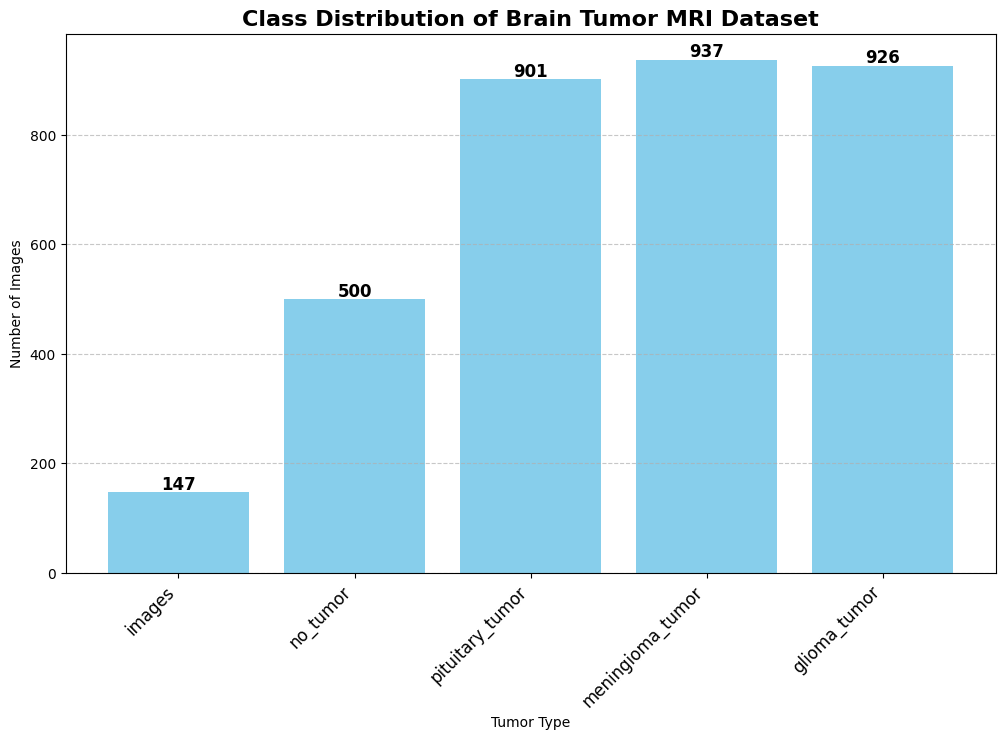

In [3]:
def plot_class_distribution(paths):
    if not paths:
        print("No image paths found.")
        return
    class_names = [os.path.basename(os.path.dirname(path)) for path in paths]
    class_counts = Counter(class_names)
    plt.figure(figsize=(12, 7))  # Increased figure size for better readability
    bars = plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
    plt.title("Class Distribution of Brain Tumor MRI Dataset", fontsize=16, fontweight='bold')
    plt.xlabel("Tumor Type")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45, ha='right', fontsize=12)
    for bar, count in zip(bars, class_counts.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, 
                 str(count), ha='center', fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()
plot_class_distribution(all_paths)

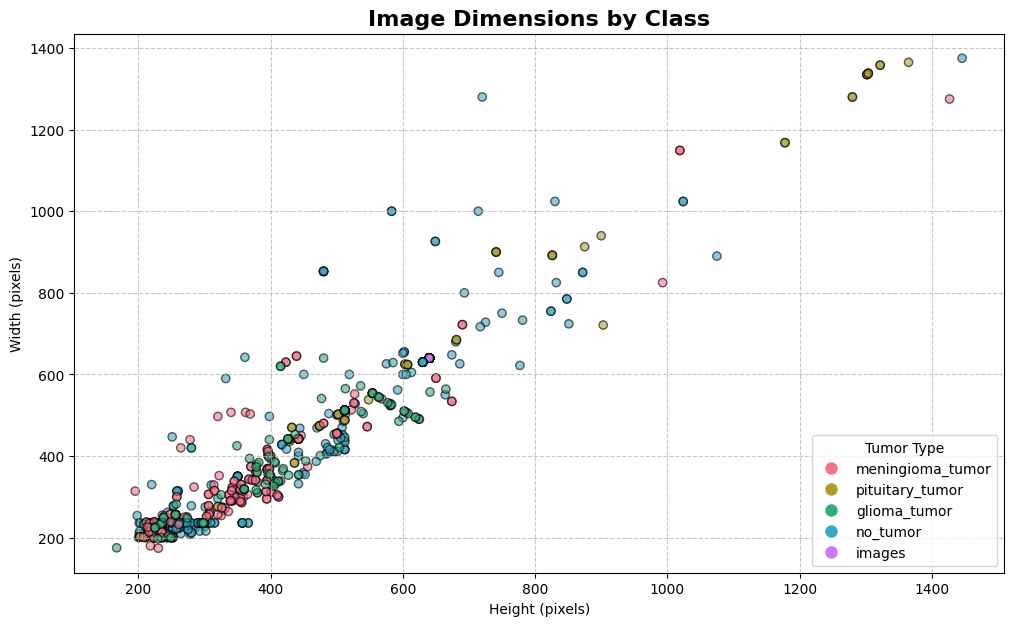

In [4]:
def plot_image_dimensions(paths):
    dimensions = [cv2.imread(path).shape[:2] for path in paths]
    heights, widths = zip(*dimensions)
    
    class_names = [os.path.basename(os.path.dirname(path)) for path in paths]

    unique_classes = list(set(class_names))
    palette = sns.color_palette("husl", len(unique_classes))
    class_to_color = {cls: palette[i] for i, cls in enumerate(unique_classes)}
    colors = [class_to_color[cls] for cls in class_names]

    plt.figure(figsize=(12, 7))
    scatter = plt.scatter(heights, widths, c=colors, alpha=0.6, edgecolor='k')
    plt.title("Image Dimensions by Class", fontsize=16, fontweight='bold')
    plt.xlabel("Height (pixels)")
    plt.ylabel("Width (pixels)")
    
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=cls, 
                                 markerfacecolor=class_to_color[cls], markersize=10)
                      for cls in unique_classes]
    plt.legend(handles=legend_handles, title="Tumor Type", loc="lower right")

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()

plot_image_dimensions(all_paths)

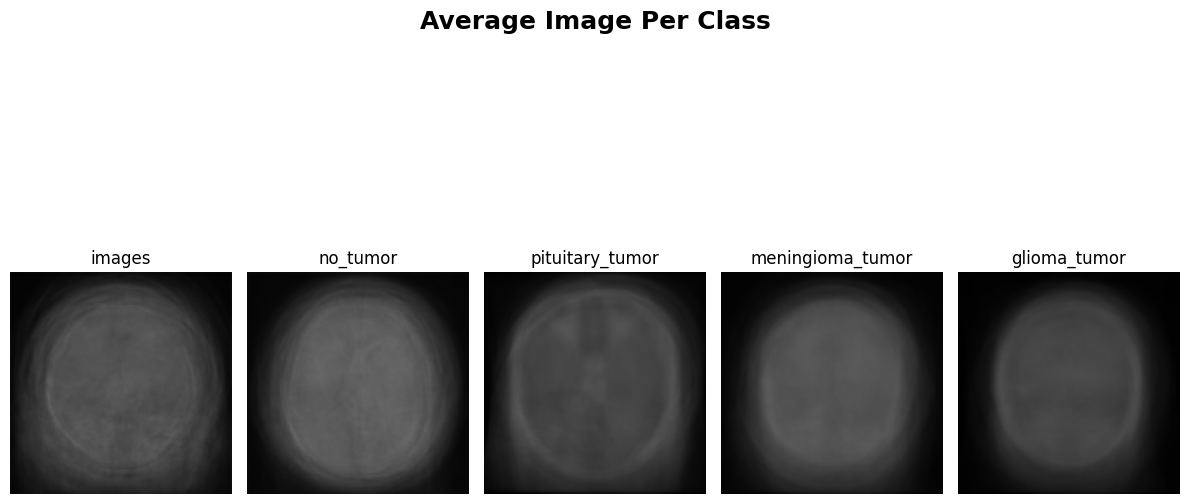

In [5]:
def calculate_average_image(paths, target_size=(128, 128)):
    imgs = [cv2.resize(cv2.imread(path), target_size) for path in paths]
    avg_img = np.mean(imgs, axis=0).astype(np.uint8)
    return avg_img

def show_average_images(paths):
    class_counts = Counter([os.path.basename(os.path.dirname(path)) for path in paths])
    class_names = list(class_counts.keys())
    
    n_classes = len(class_names)
    fig, axes = plt.subplots(1, n_classes, figsize=(12, 7))
    fig.suptitle("Average Image Per Class", fontsize=18, fontweight='bold')

    for ax, tumor_type in zip(axes, class_names):
        tumor_paths = [p for p in paths if tumor_type in p]
        avg_img = calculate_average_image(tumor_paths)
        
        ax.imshow(cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB)) 
        ax.set_title(f"{tumor_type}", fontsize=12)
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

show_average_images(all_paths)

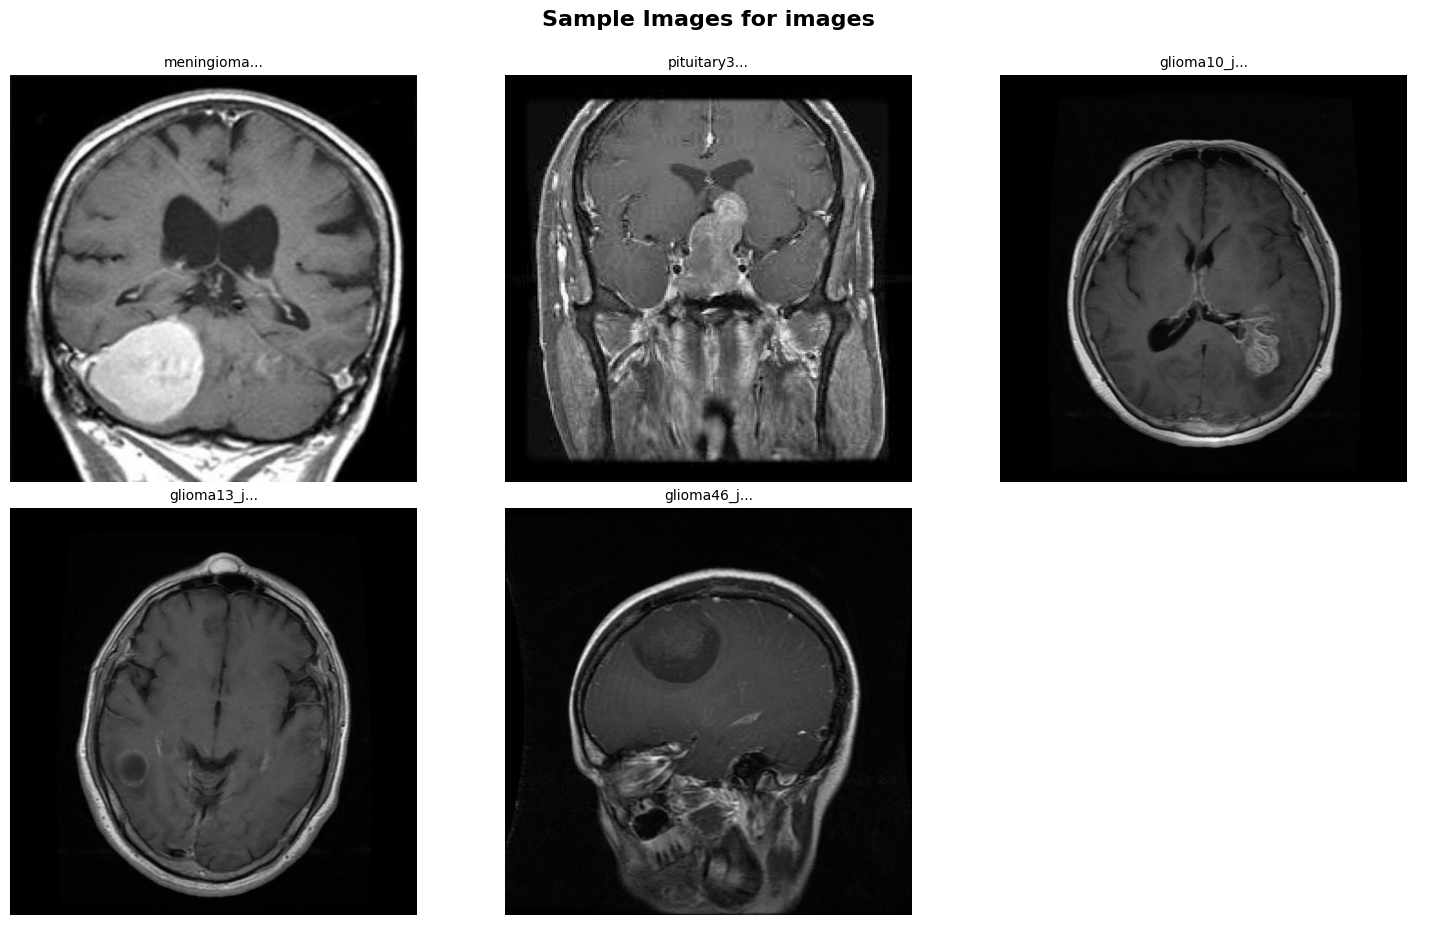

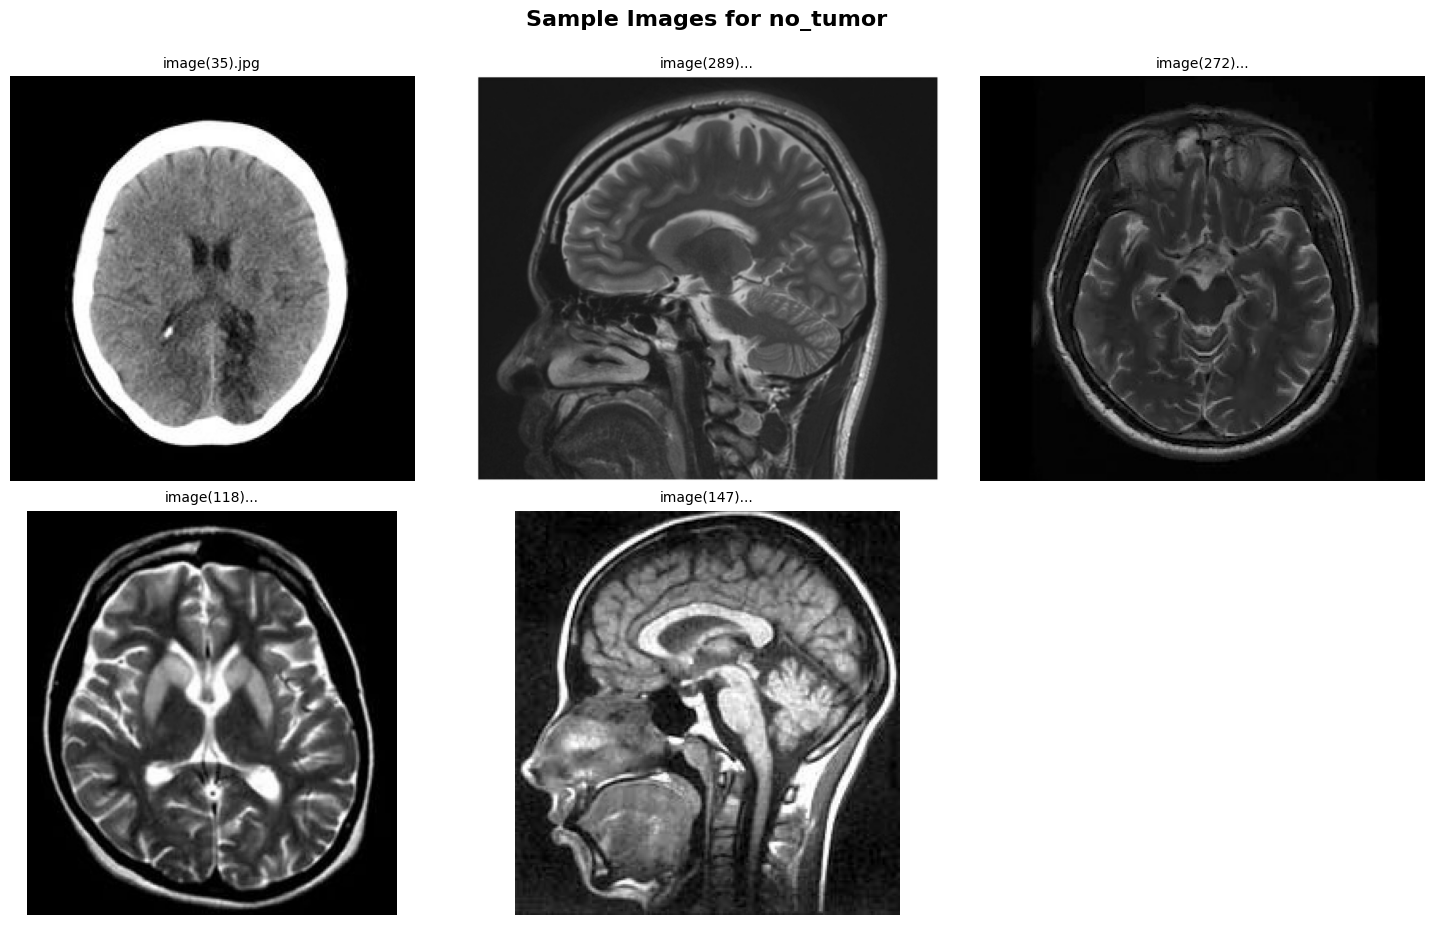

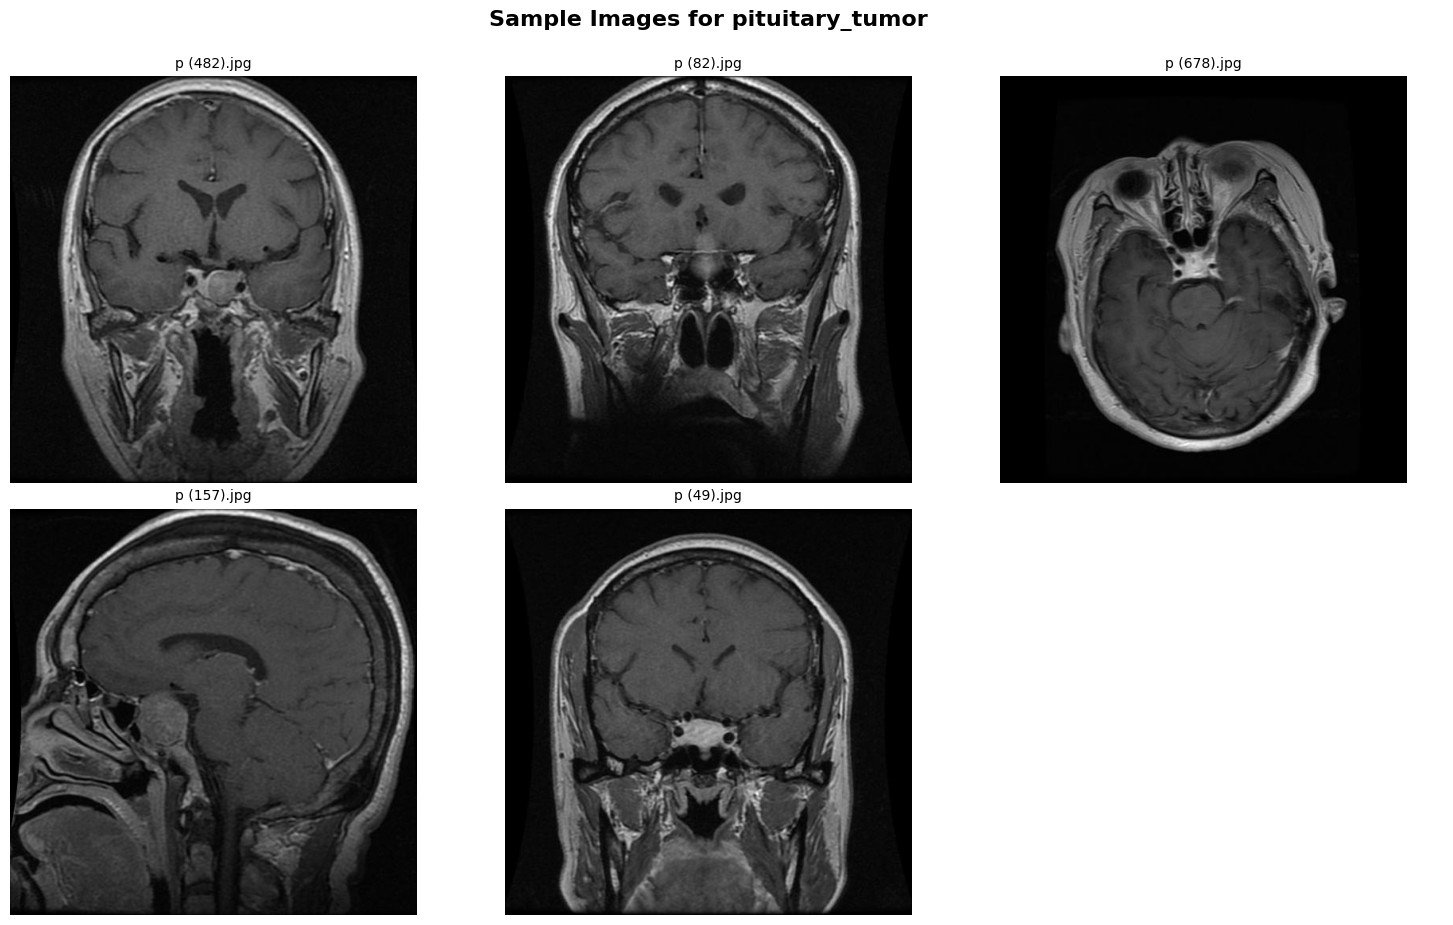

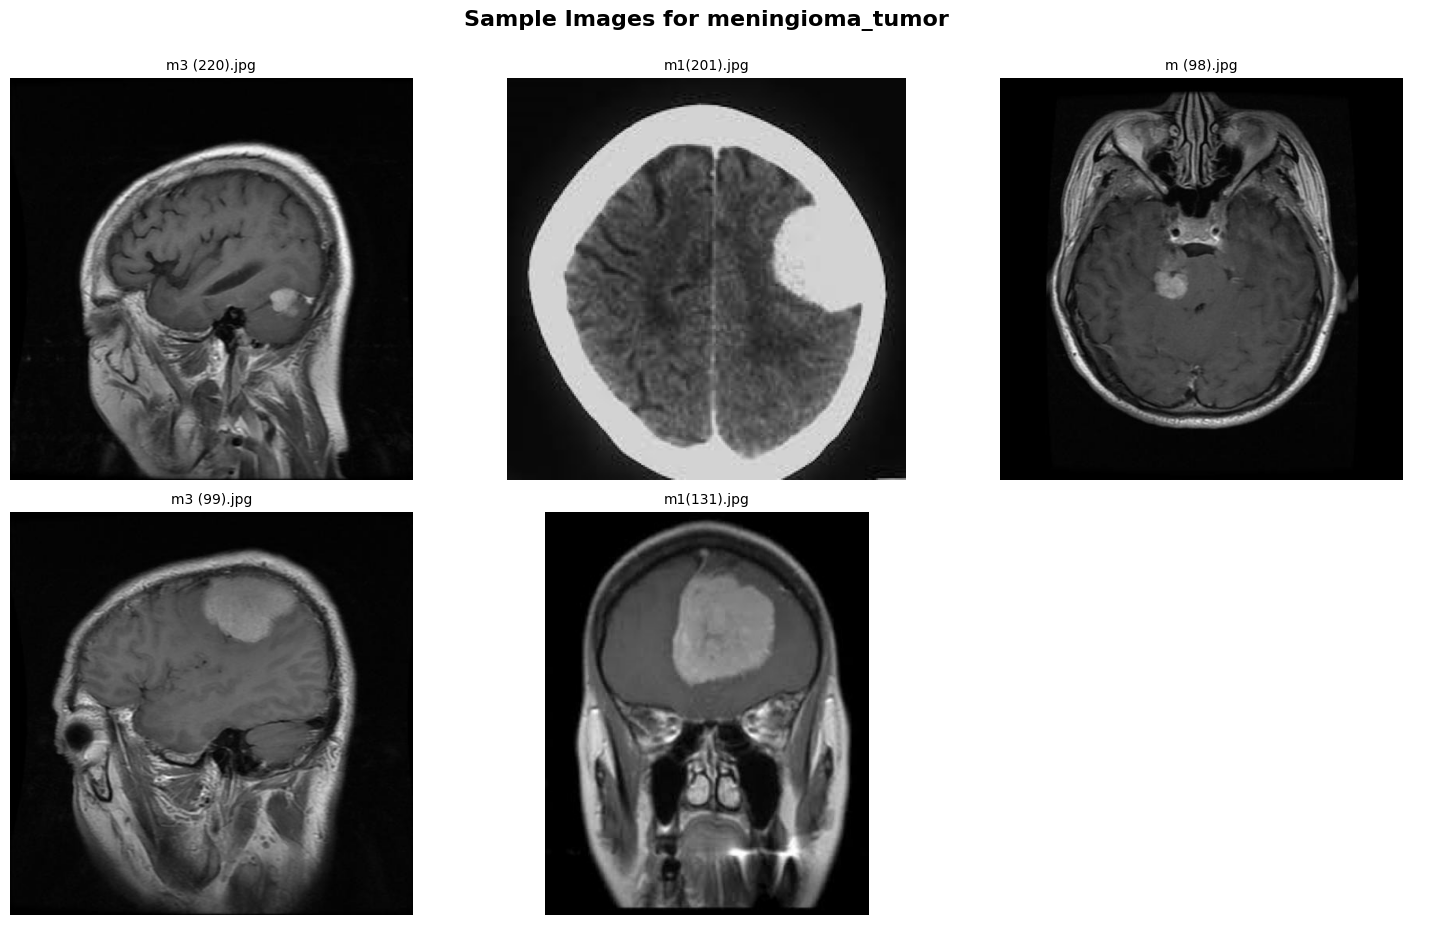

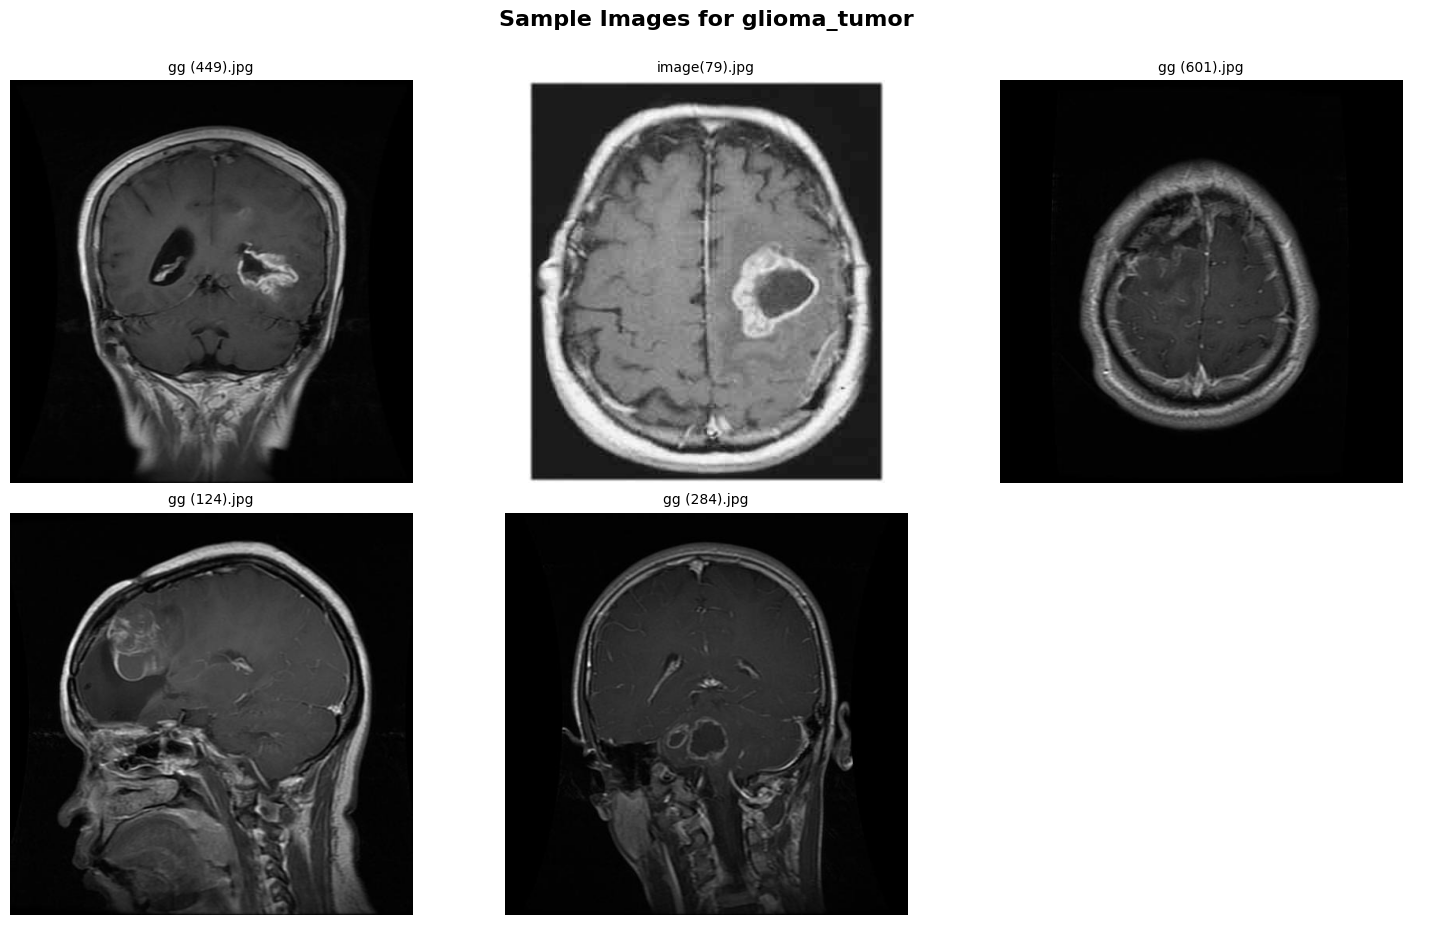

In [6]:
def show_sample_images(paths, tumor_type, n=5, images_per_row=3):
    sample_paths = random.sample(paths, n)
    
    num_rows = (n + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 5))
    fig.suptitle(f"Sample Images for {tumor_type}", fontsize=16, fontweight='bold', y=0.92)
    
    axes = axes.flatten() if n > 1 else [axes]

    for i, (ax, path) in enumerate(zip(axes, sample_paths)):
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        title = os.path.basename(path)
        ax.set_title(title[:10] + '...' if len(title) > 13 else title, fontsize=10)
        ax.axis('off')
    
    for ax in axes[len(sample_paths):]:
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.92]) 
    plt.show()

def display_class_samples(paths, n=5, images_per_row=3):

    class_counts = Counter([os.path.basename(os.path.dirname(path)) for path in paths])
    
    for tumor_type in class_counts.keys():
        tumor_paths = [p for p in paths if tumor_type in p]
        show_sample_images(tumor_paths, tumor_type, n=n, images_per_row=images_per_row)

display_class_samples(all_paths, n=5, images_per_row=3)

Augmentation previews for class: images


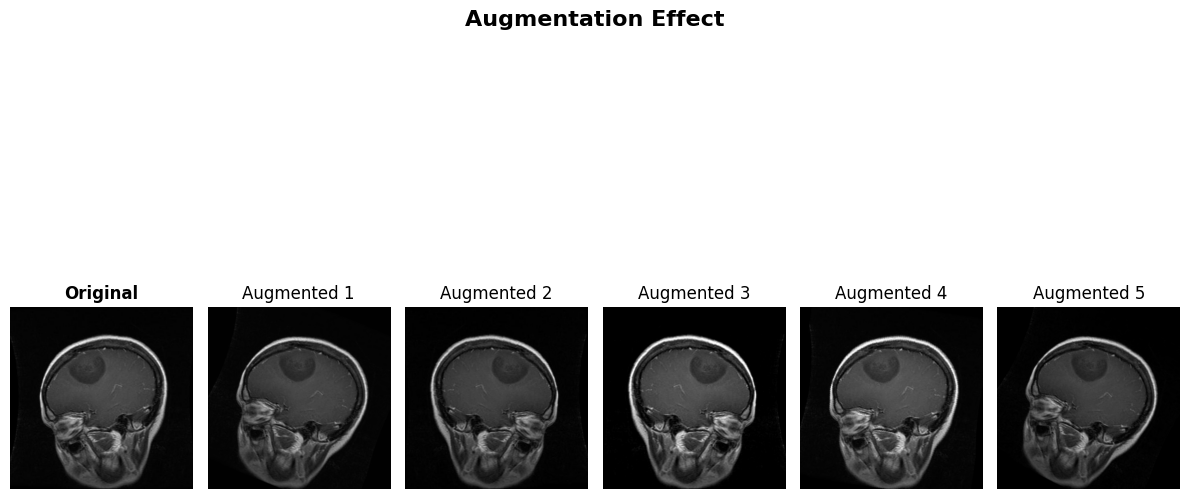

Augmentation previews for class: no_tumor


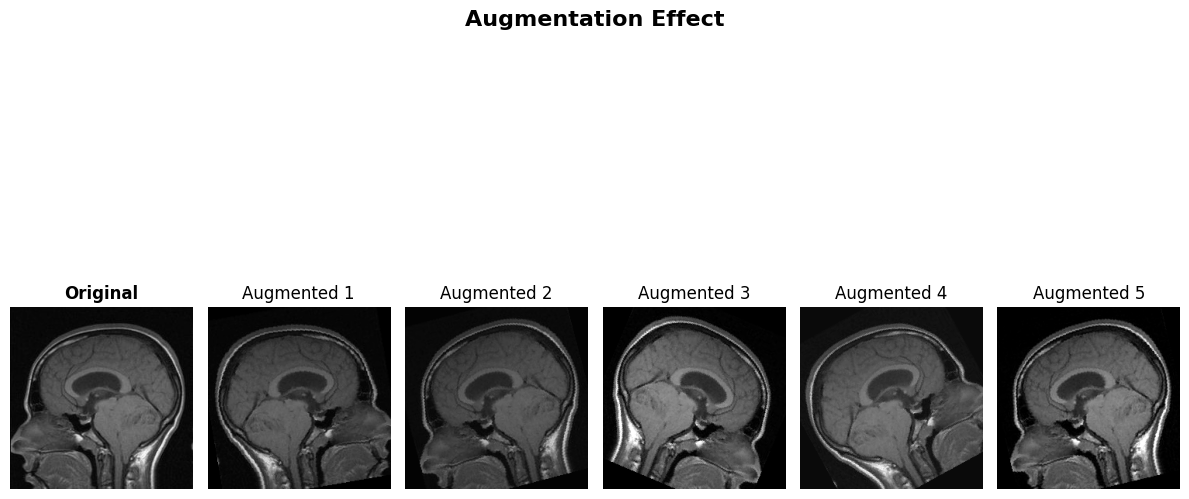

Augmentation previews for class: pituitary_tumor


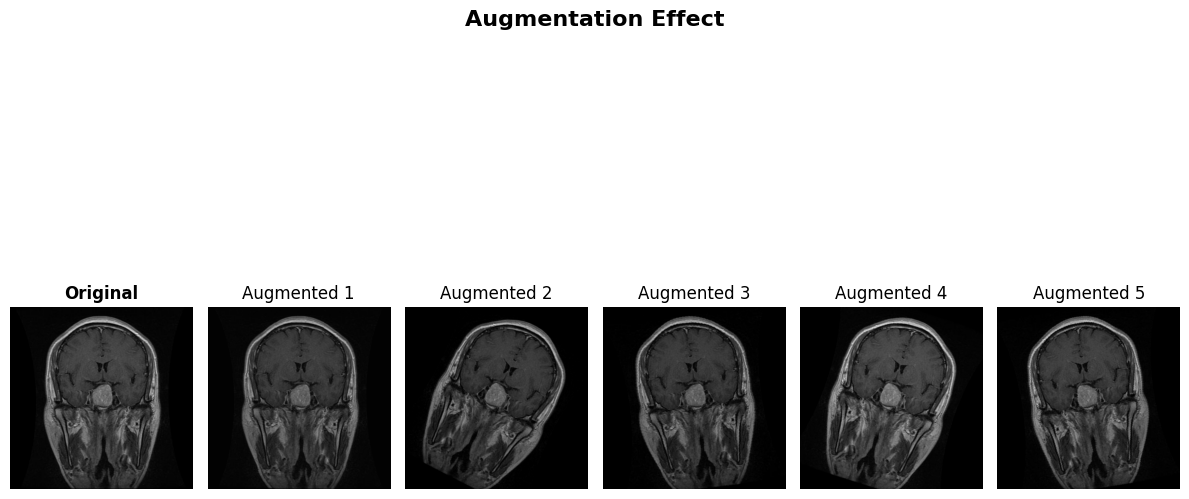

Augmentation previews for class: meningioma_tumor


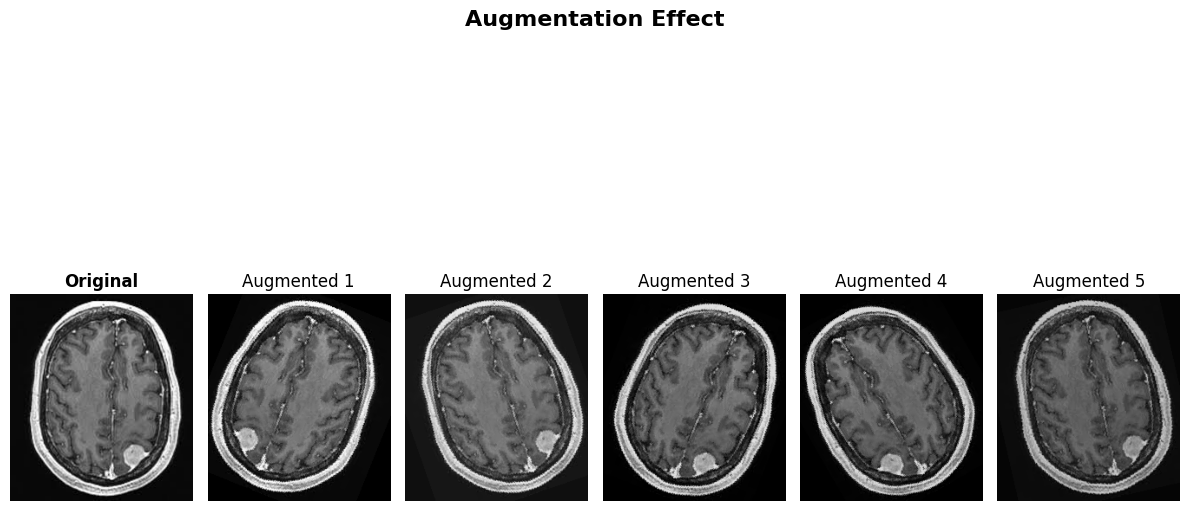

Augmentation previews for class: glioma_tumor


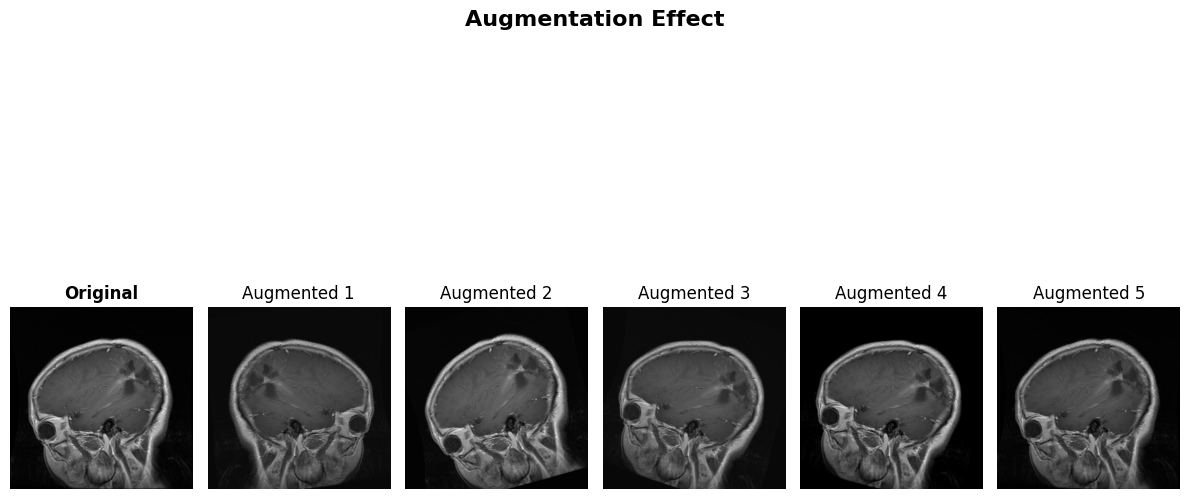

In [7]:
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

def show_augmented_images(path, n=5):
    image = Image.open(path)
    
    fig, axes = plt.subplots(1, n+1, figsize=(12, 7))
    fig.suptitle("Augmentation Effect", fontsize=16, fontweight='bold')
    
    axes[0].imshow(image)
    axes[0].set_title("Original", fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    for i in range(1, n+1):
        augmented_img = augmentation(image)
        axes[i].imshow(augmented_img)
        axes[i].set_title(f"Augmented {i}", fontsize=12)
        axes[i].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

def display_class_augmentations(paths, n=5):
    class_counts = Counter([os.path.basename(os.path.dirname(path)) for path in paths])
    
    for tumor_type in class_counts.keys():
        tumor_paths = [p for p in paths if tumor_type in p]
        print(f"Augmentation previews for class: {tumor_type}")
        show_augmented_images(tumor_paths[0], n=n)

display_class_augmentations(all_paths)

In [8]:
train_dir = 'brain_tumor_dataset/brain_tumor_classification/Training' 
test_dir = 'brain-tumor-mri-dataset/brain_tumor_dataset/brain_tumor_classification/Testing'    

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = ImageFolder(root=train_dir, transform=data_transforms['train'])
val_size = int(0.2 * len(train_dataset)) 
train_size = len(train_dataset) - val_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

test_dataset = ImageFolder(root=test_dir, transform=data_transforms['val'])

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 4


In [10]:
model = models.efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[1].in_features, num_classes)  
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 149MB/s]


In [11]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}
dataset_sizes = {
    'train': len(train_ds),
    'val': len(val_ds)
}
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 5  

In [12]:
num_epochs = 10
accumulation_steps = 4 
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    
    for i, (images, labels) in enumerate(tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}")):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels) / accumulation_steps  

        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()  
            optimizer.zero_grad()

        running_loss += loss.item() * labels.size(0)

    train_loss = running_loss / dataset_sizes['train']
    train_losses.append(train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * labels.size(0)
    
    val_loss = val_running_loss / dataset_sizes['val']
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement == patience:
            print("Early stopping triggered.")
            break

    scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

model.load_state_dict(best_model_wts)

Epoch 10/10: 100%|██████████| 144/144 [35:44<00:00, 14.89s/it]


Epoch 10/10 - Train Loss: 0.0023 - Validation Loss: 0.0388


<All keys matched successfully>

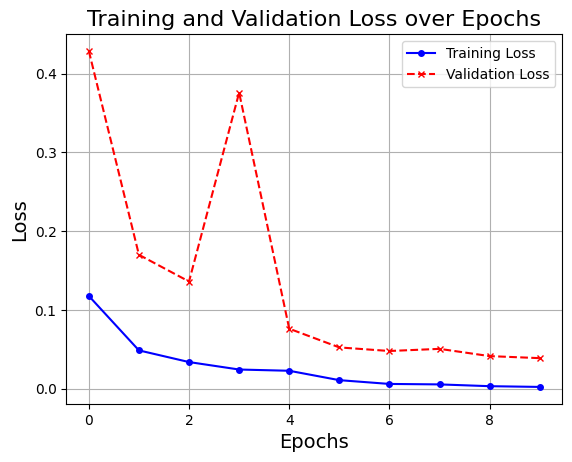

In [13]:
plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', marker='x', markersize=4)

plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend()

plt.grid(True)
plt.show()

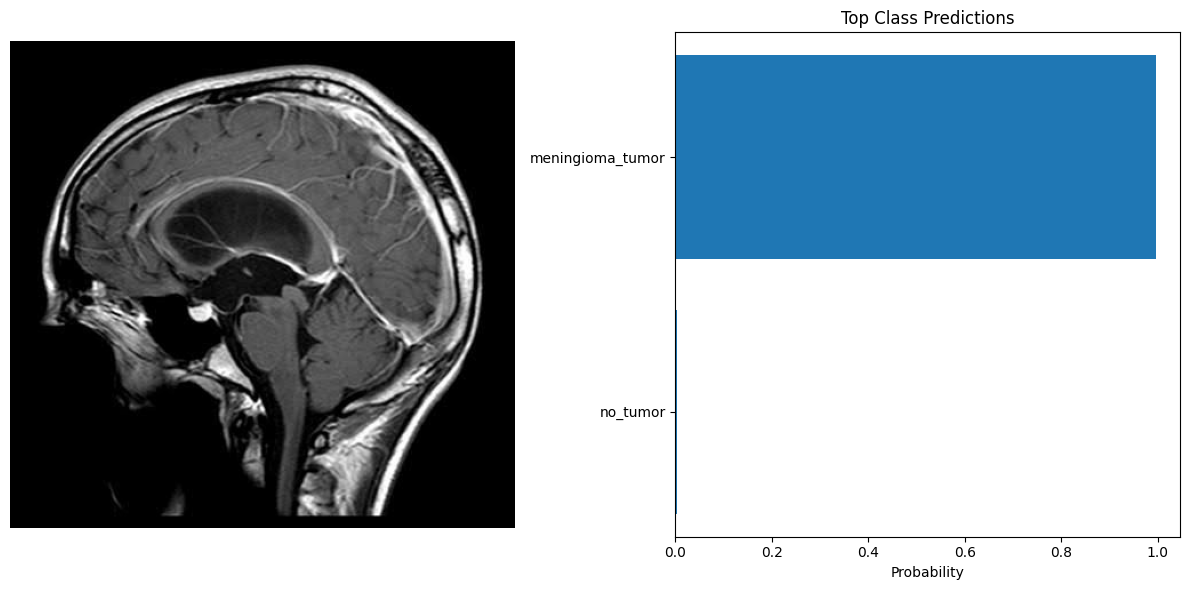

Image 1:
  Actual class: glioma_tumor
  Predicted class: meningioma_tumor
------------------------------


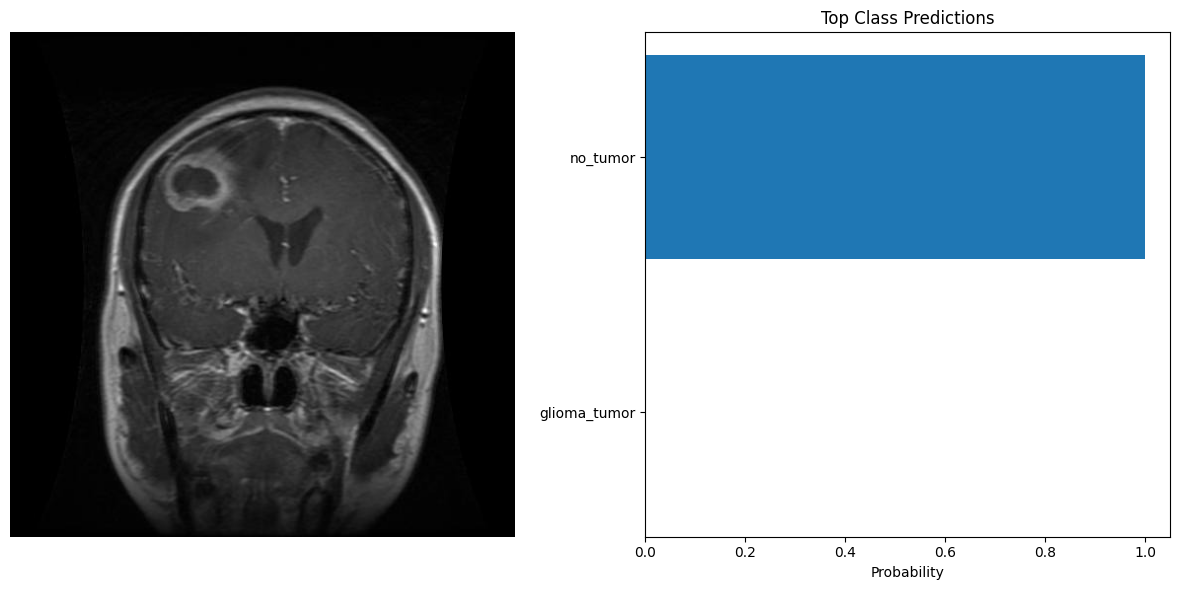

Image 2:
  Actual class: glioma_tumor
  Predicted class: no_tumor
------------------------------


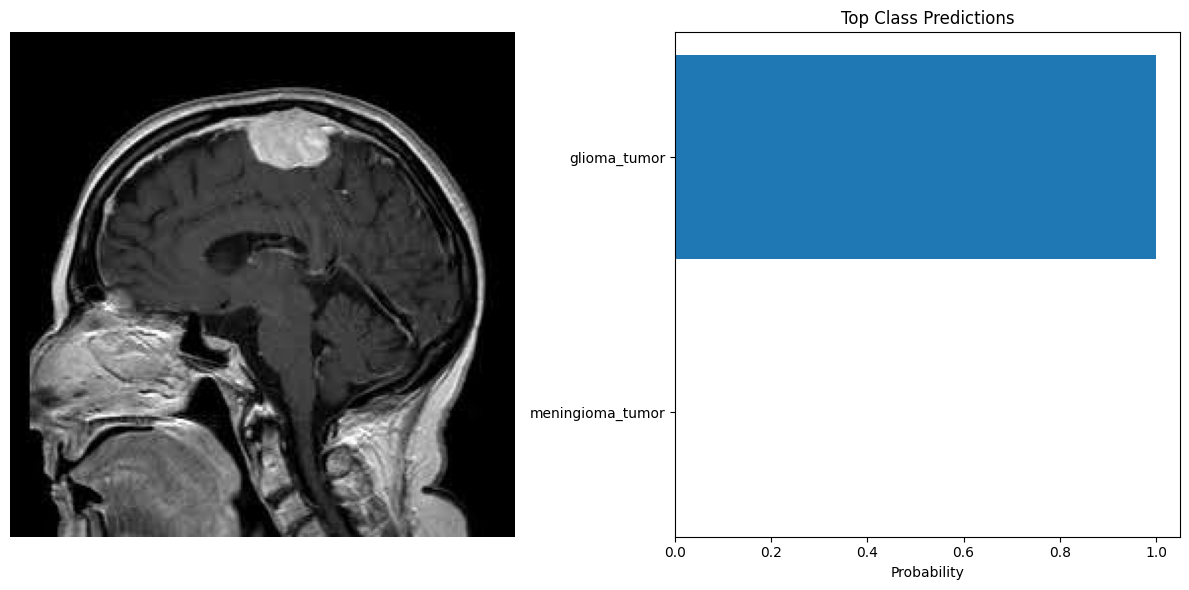

Image 3:
  Actual class: meningioma_tumor
  Predicted class: glioma_tumor
------------------------------


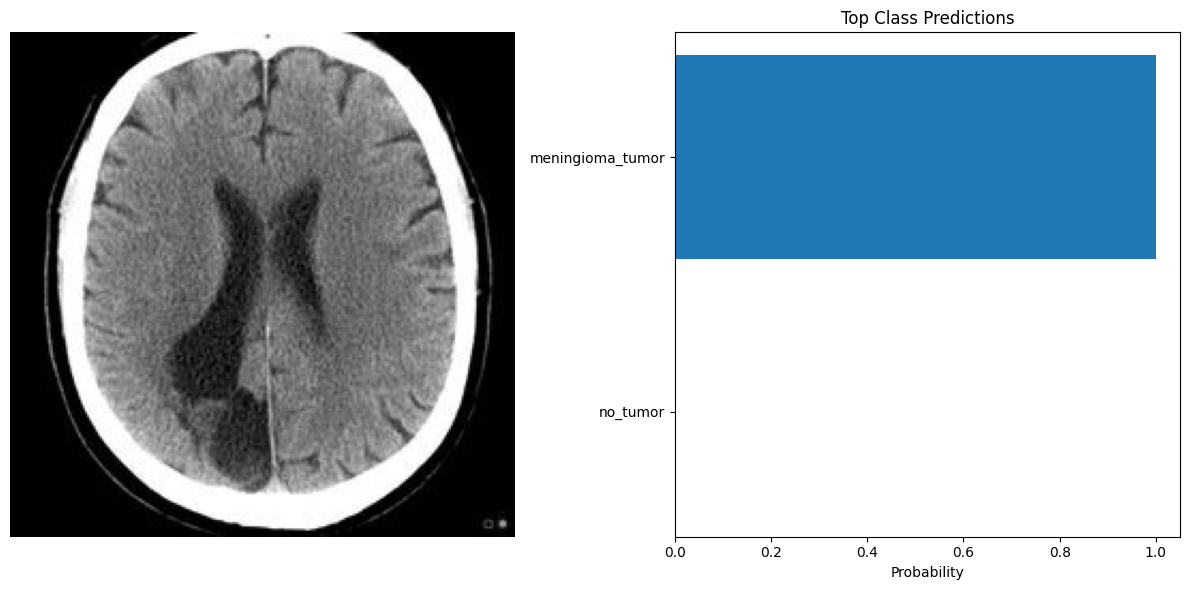

Image 4:
  Actual class: no_tumor
  Predicted class: meningioma_tumor
------------------------------


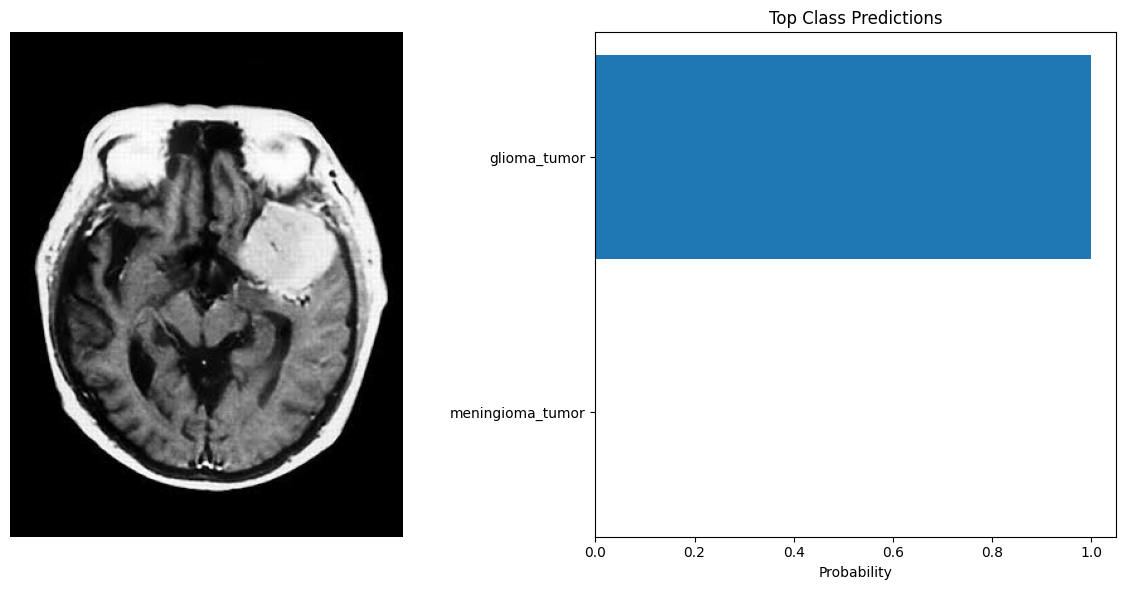

Image 5:
  Actual class: meningioma_tumor
  Predicted class: glioma_tumor
------------------------------


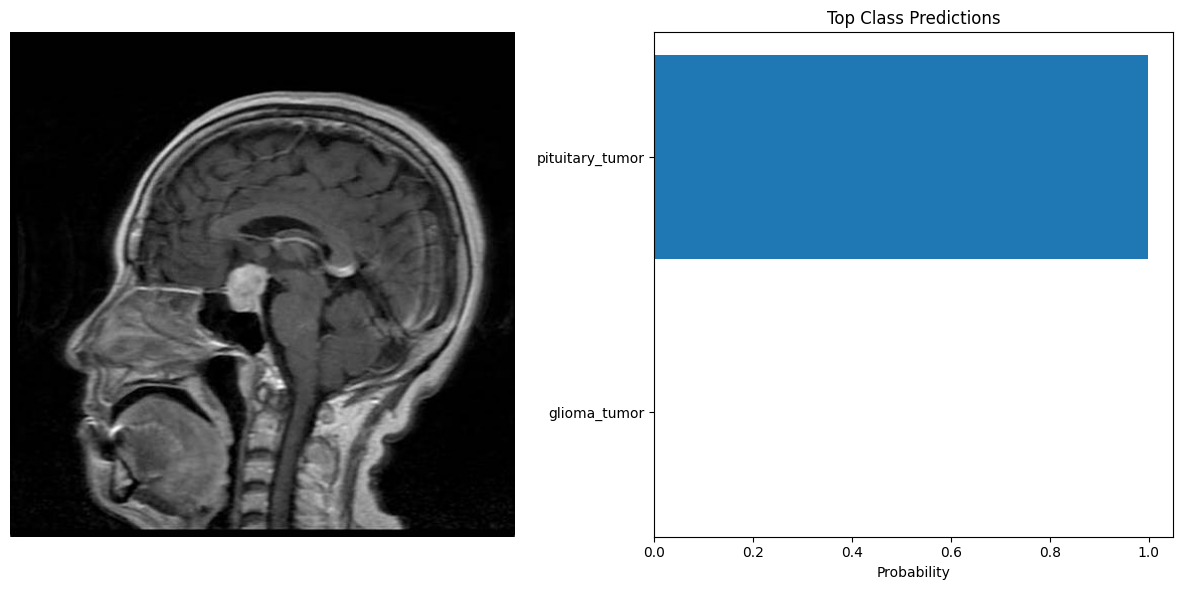

Image 6:
  Actual class: pituitary_tumor
  Predicted class: pituitary_tumor
------------------------------


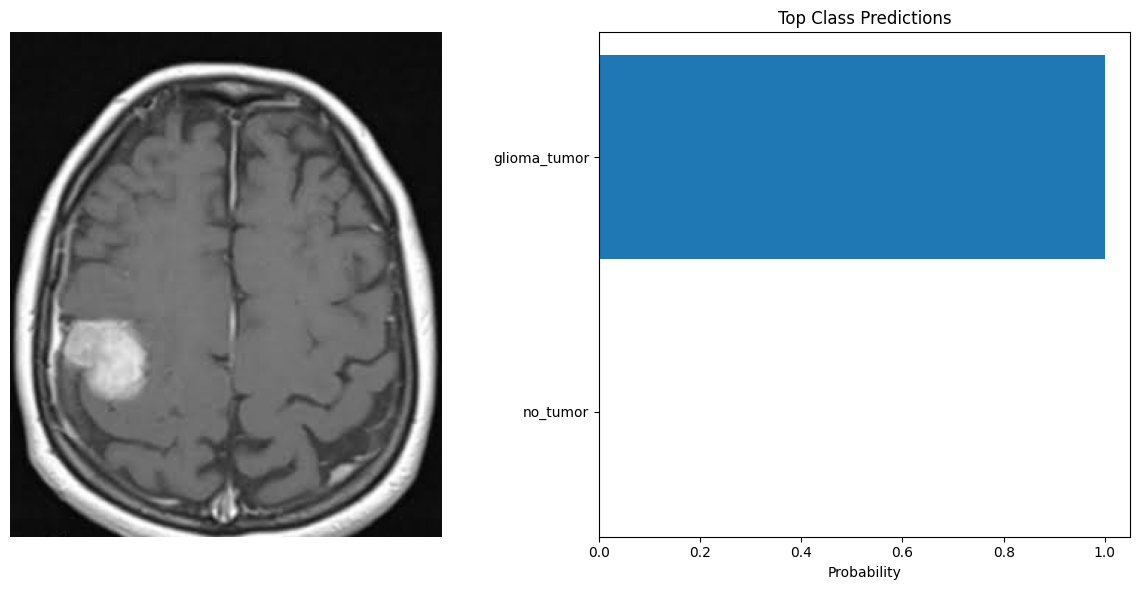

Image 7:
  Actual class: meningioma_tumor
  Predicted class: glioma_tumor
------------------------------


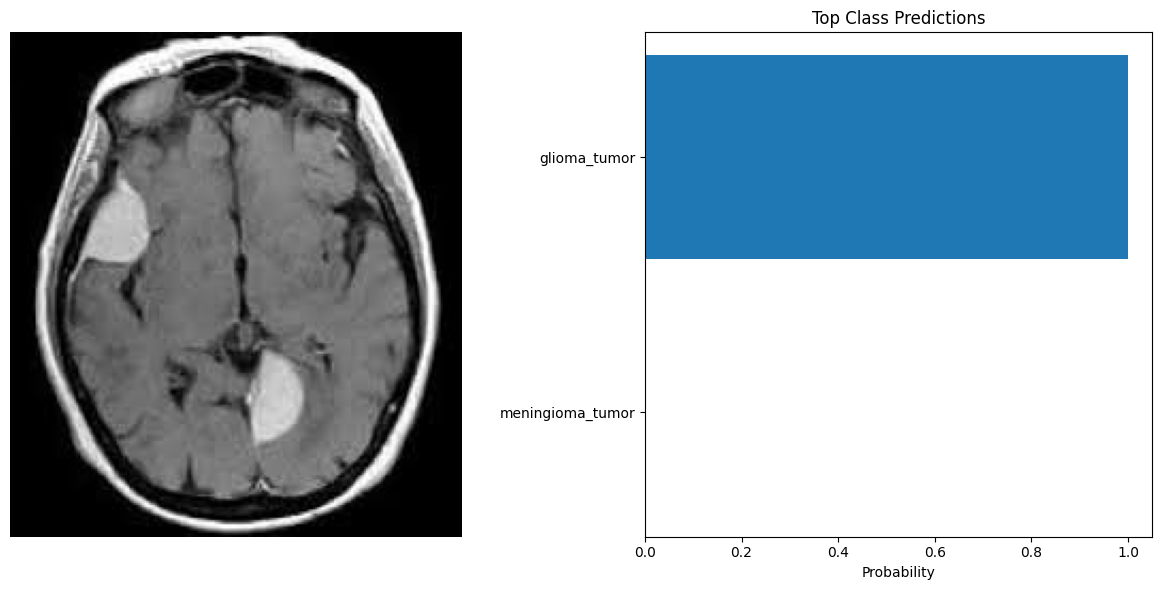

Image 8:
  Actual class: meningioma_tumor
  Predicted class: glioma_tumor
------------------------------


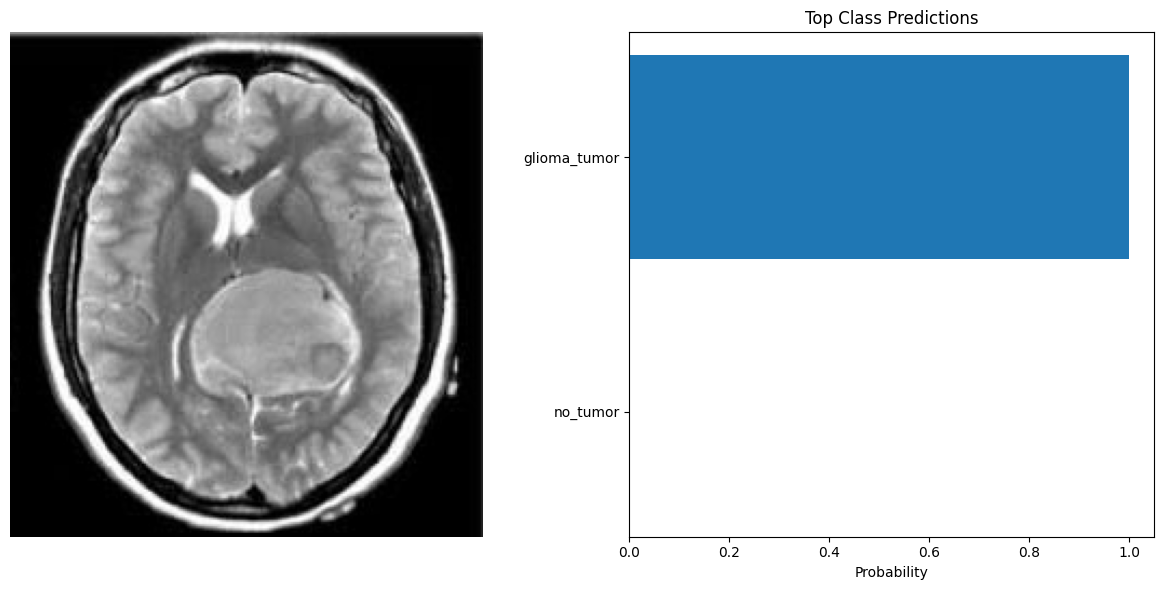

Image 9:
  Actual class: meningioma_tumor
  Predicted class: glioma_tumor
------------------------------


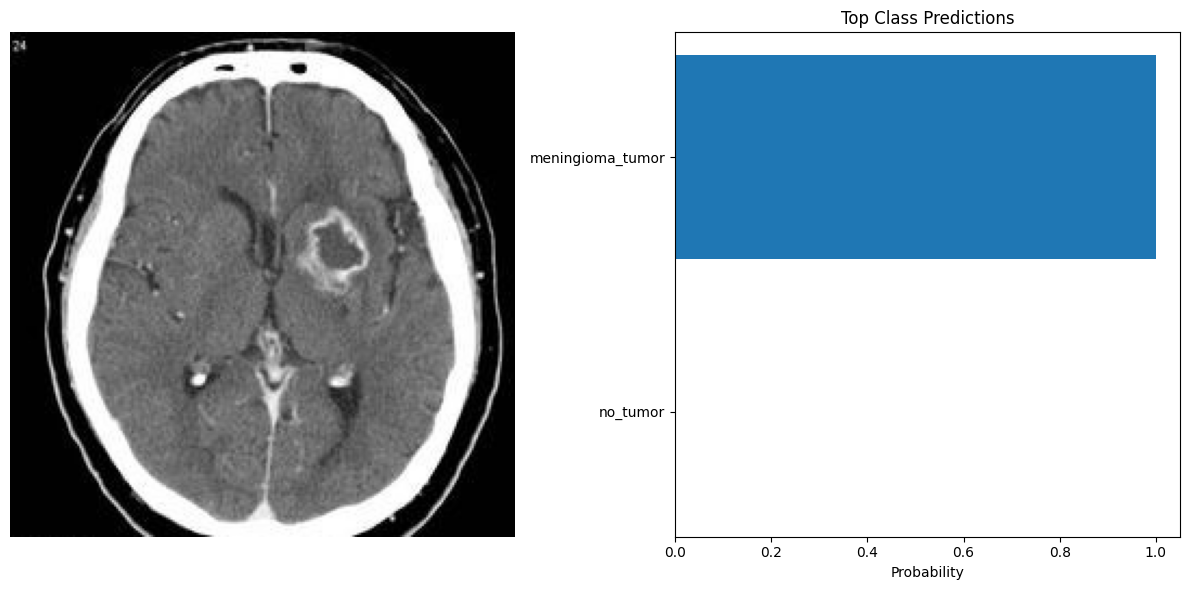

Image 10:
  Actual class: glioma_tumor
  Predicted class: meningioma_tumor
------------------------------


In [14]:
def load_and_preprocess_image(image_path, transform):
    """
    Loads an image, converts it to RGB, applies transformations, and prepares it for model input.
    
    Args:
        image_path (str): File path of the image to load.
        transform (torchvision.transforms.Compose): Transformations to apply.
        
    Returns:
        tuple: Original PIL image and preprocessed tensor ready for model input.
    """
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)
def predict_image(model, image_path, transform, device):
    """
    Loads and preprocesses an image, then uses the model to predict class probabilities.
    
    Args:
        model (torch.nn.Module): Trained model.
        image_path (str): Path to the image file.
        transform (torchvision.transforms.Compose): Transformations to apply.
        device (torch.device): Device for model (CPU or GPU).
        
    Returns:
        tuple: Original image and class probabilities as a numpy array.
    """
    original_image, image_tensor = load_and_preprocess_image(image_path, transform)
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
    
    return original_image, probabilities.cpu().numpy().flatten()

def visualize_predictions(image, probabilities, class_names, top_k=2):
    """
    Displays the image and a bar chart of the top-k predictions.
    
    Args:
        image (PIL.Image): Original image.
        probabilities (np.array): Array of class probabilities.
        class_names (list): Class names for predictions.
        top_k (int): Number of top predictions to display.
    """
    top_k_idx = probabilities.argsort()[-top_k:][::-1]
    top_classes = [class_names[i] for i in top_k_idx]
    top_probabilities = probabilities[top_k_idx]

    fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
    axarr[0].imshow(image)
    axarr[0].axis("off")
    
    axarr[1].barh(top_classes, top_probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Top Class Predictions")
    axarr[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def get_random_image_from_folder(folder_path):
    """
    Selects a random image from a specified folder organized by class.
    
    Args:
        folder_path (str): Path to the root folder containing class subfolders.
        
    Returns:
        tuple: File path to a randomly selected image and its actual class label.
    """
    classes = os.listdir(folder_path)
    random_class = random.choice(classes)
    class_folder = os.path.join(folder_path, random_class)
    image_files = os.listdir(class_folder)
    random_image_file = random.choice(image_files)
    return os.path.join(class_folder, random_image_file), random_class
test_folder_path = "/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/brain_tumor_classification/Testing"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class_names = ["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"]

for i in range(10):  
    test_image_path, actual_class = get_random_image_from_folder(test_folder_path)
    original_image, probabilities = predict_image(model, test_image_path, transform, device)
    visualize_predictions(original_image, probabilities, class_names)
    
    predicted_class_idx = probabilities.argmax()
    predicted_class = class_names[predicted_class_idx]
    print(f"Image {i+1}:")
    print(f"  Actual class: {actual_class}")
    print(f"  Predicted class: {predicted_class}")
    print("-" * 30)

Test Accuracy: 98.2578%
Precision: 0.9800
Recall: 0.9855
F1 Score: 0.9826
Confusion Matrix:
[[158   2   0   0]
 [  2 172   2   3]
 [  0   0  78   0]
 [  0   0   1 156]]


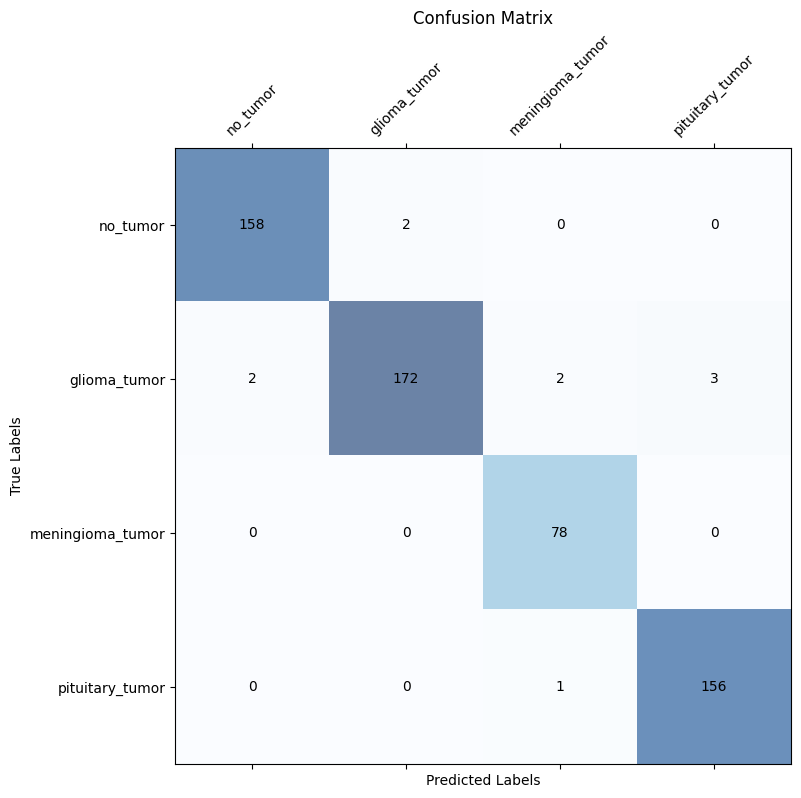

In [15]:

def evaluate_model(model, dataloader, class_names, device):
    model.eval()  
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = running_corrects.double() / len(dataloader.dataset) * 100
    print(f'Test Accuracy: {accuracy:.4f}%')

    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.6)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
    plt.yticks(ticks=range(len(class_names)), labels=class_names)
    plt.show()
class_names = ["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"] 
evaluate_model(model, dataloaders['val'], class_names, device)  